# 🚀 NASA Exoplanet Classification - EDA & Model Development

## 2025 NASA Space Apps Challenge: "A World Away: Hunting for Exoplanets with AI"

This notebook provides a comprehensive analysis and machine learning pipeline for classifying exoplanets using NASA's open datasets from the Kepler, K2, and TESS missions.

### Project Overview
- **Objective**: Build an AI/ML classifier to automatically identify exoplanets
- **Datasets**: Kepler Objects of Interest (KOI), K2 Planets and Candidates, TESS Objects of Interest (TOI)
- **Classifications**: Confirmed Planet, Planetary Candidate, False Positive
- **Approach**: Ensemble ML pipeline with feature engineering and model explainability

### Notebook Structure
1. **Data Loading & Exploration**: Understanding NASA exoplanet datasets
2. **Data Preprocessing**: Cleaning, feature engineering, and preparation
3. **Exploratory Data Analysis**: Visualizing exoplanet characteristics
4. **Model Training**: Baseline and advanced ML models
5. **Model Evaluation**: Performance metrics and comparison
6. **Feature Analysis**: Understanding what drives classifications
7. **Model Export**: Saving for production deployment

---

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.impute import SimpleImputer

# Advanced ML models (install if needed)
try:
    import xgboost as xgb
    from lightgbm import LGBMClassifier
    print("✅ Advanced ML libraries loaded successfully")
except ImportError:
    print("⚠️ XGBoost/LightGBM not available. Install with: pip install xgboost lightgbm")

# Model persistence
import joblib

# Add project src to path for custom modules
sys.path.append('../src')

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("🚀 Libraries loaded successfully!")
print(f"📍 Working directory: {Path.cwd()}")
print(f"🐍 Python version: {sys.version}")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🧮 NumPy version: {np.__version__}")

✅ Advanced ML libraries loaded successfully
🚀 Libraries loaded successfully!
📍 Working directory: C:\Users\harsh\Exoplanet-Classifier-NASA-KOI-K2-TESS-\notebooks
🐍 Python version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
📊 Pandas version: 2.3.2
🧮 NumPy version: 2.3.3


## 📊 Load and Explore NASA Exoplanet Datasets

We'll work with three major NASA exoplanet datasets:

### Datasets Overview
- **Kepler Objects of Interest (KOI)**: Objects identified by the Kepler mission as potential exoplanets
- **K2 Planets and Candidates**: Extended mission data from the K2 mission
- **TESS Objects of Interest (TOI)**: Transiting exoplanet candidates from the TESS mission

### Target Classifications
- **CONFIRMED**: Verified exoplanets with high confidence
- **CANDIDATE**: Objects with planetary-like signals requiring further validation  
- **FALSE POSITIVE**: Objects that mimic planetary signals but are not planets

In [2]:
# Load NASA Exoplanet Datasets
print("🔍 Loading NASA exoplanet datasets...")

# Import custom data loader
try:
    from data_loader import ExoplanetDataLoader
    
    # Initialize data loader
    loader = ExoplanetDataLoader(data_dir="../data")
    
    # Check dataset availability
    print("\n📋 Dataset Information:")
    info_df = loader.get_dataset_info()
    display(info_df)
    
    # Download datasets if needed
    print("\n📥 Checking dataset availability...")
    datasets_available = []
    
    # Try to load existing datasets first
    datasets = loader.load_all_datasets()
    
    if not datasets:
        print("No datasets found. Attempting to download...")
        download_results = loader.download_all_datasets()
        
        for dataset, success in download_results.items():
            if success:
                print(f"✅ {dataset.upper()} downloaded successfully")
            else:
                print(f"❌ Failed to download {dataset.upper()}")
        
        # Retry loading after download
        datasets = loader.load_all_datasets()
    
    print(f"\n📊 Successfully loaded {len(datasets)} datasets")
    
    # Display basic information about each dataset
    for name, df in datasets.items():
        print(f"\n{name.upper()} Dataset:")
        print(f"  Shape: {df.shape}")
        print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
        
        # Check for target column
        target_cols = {
            'koi': 'koi_disposition', 
            'k2': 'k2c_disp', 
            'toi': 'tfopwg_disp'
        }
        target_col = target_cols.get(name)
        
        if target_col and target_col in df.columns:
            print(f"  Target column: {target_col}")
            print(f"  Target distribution:")
            print(f"    {df[target_col].value_counts().to_dict()}")
        else:
            print(f"  ⚠️ Target column not found")

except ImportError:
    print("❌ Custom data loader not available. Loading datasets manually...")
    
    # Manual dataset loading fallback
    datasets = {}
    data_dir = Path("../data/raw")
    
    dataset_files = {
        'koi': 'koi.csv',
        'k2': 'k2candidates.csv', 
        'toi': 'toi.csv'
    }
    
    for name, filename in dataset_files.items():
        filepath = data_dir / filename
        if filepath.exists():
            try:
                df = pd.read_csv(filepath, low_memory=False)
                datasets[name] = df
                print(f"✅ Loaded {name.upper()}: {df.shape}")
            except Exception as e:
                print(f"❌ Failed to load {name.upper()}: {e}")
        else:
            print(f"⚠️ Dataset file not found: {filepath}")

print(f"\n🎉 Data loading complete! Available datasets: {list(datasets.keys())}")

🔍 Loading NASA exoplanet datasets...

📋 Dataset Information:


,Dataset,Description,Target Column,File Exists,Size (MB),Records
0,KOI,Kepler Objects of Interest,disposition,True,11.19,Error
1,K2,K2 Candidates,disposition,True,7.59,Error
2,TOI,TESS Objects of Interest,disposition,True,4.18,Error


INFO:data_loader:Loading Kepler Objects of Interest...



📥 Checking dataset availability...


INFO:data_loader:Loaded 9564 records from Kepler Objects of Interest
INFO:data_loader:Loading K2 Candidates...
INFO:data_loader:Loaded 4004 records from K2 Candidates
INFO:data_loader:Loading TESS Objects of Interest...
INFO:data_loader:Loaded 7699 records from TESS Objects of Interest



📊 Successfully loaded 3 datasets

KOI Dataset:
  Shape: (9564, 141)
  Memory usage: 20.9 MB
  Target column: koi_disposition
  Target distribution:
    {'FALSE POSITIVE': 4839, 'CONFIRMED': 2746, 'CANDIDATE': 1979}

K2 Dataset:
  Shape: (4004, 295)
  Memory usage: 17.6 MB
  ⚠️ Target column not found

TOI Dataset:
  Shape: (7699, 87)
  Memory usage: 7.4 MB
  Target column: tfopwg_disp
  Target distribution:
    {'PC': 4678, 'FP': 1196, 'CP': 683, 'KP': 583, 'APC': 461, 'FA': 98}

🎉 Data loading complete! Available datasets: ['koi', 'k2', 'toi']


In [3]:
# Explore Dataset Structure and Content
if datasets:
    print("🔬 Detailed Dataset Exploration\n")
    
    for dataset_name, df in datasets.items():
        print(f"{'='*60}")
        print(f"📊 {dataset_name.upper()} DATASET ANALYSIS")
        print(f"{'='*60}")
        
        # Basic info
        print(f"\n📐 Shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
        print(f"💾 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
        
        # Data types
        print(f"\n📋 Data Types:")
        dtype_counts = df.dtypes.value_counts()
        for dtype, count in dtype_counts.items():
            print(f"  {dtype}: {count} columns")
        
        # Missing values analysis
        missing_data = df.isnull().sum()
        missing_pct = (missing_data / len(df)) * 100
        missing_summary = pd.DataFrame({
            'Missing_Count': missing_data,
            'Missing_Percentage': missing_pct
        }).sort_values('Missing_Percentage', ascending=False)
        
        top_missing = missing_summary[missing_summary['Missing_Percentage'] > 0].head(10)
        
        if not top_missing.empty:
            print(f"\n❌ Top Columns with Missing Values:")
            for col, row in top_missing.iterrows():
                print(f"  {col}: {row['Missing_Count']:,} ({row['Missing_Percentage']:.1f}%)")
        else:
            print(f"\n✅ No missing values found!")
        
        # Sample of data
        print(f"\n👀 Sample Data (first 3 rows):")
        display(df.head(3))
        
        print("\n" + "-"*60 + "\n")

else:
    print("❌ No datasets available for exploration")

🔬 Detailed Dataset Exploration

📊 KOI DATASET ANALYSIS

📐 Shape: 9,564 rows × 141 columns
💾 Memory Usage: 20.9 MB

📋 Data Types:
  float64: 117 columns
  object: 17 columns
  int64: 7 columns

❌ Top Columns with Missing Values:
  koi_incl_err1: 9,564.0 (100.0%)
  koi_sma_err2: 9,564.0 (100.0%)
  koi_sma_err1: 9,564.0 (100.0%)
  koi_teq_err1: 9,564.0 (100.0%)
  koi_teq_err2: 9,564.0 (100.0%)
  koi_longp_err2: 9,564.0 (100.0%)
  koi_ingress: 9,564.0 (100.0%)
  koi_ingress_err2: 9,564.0 (100.0%)
  koi_ingress_err1: 9,564.0 (100.0%)
  koi_longp_err1: 9,564.0 (100.0%)

👀 Sample Data (first 3 rows):


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.200,0.16,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,...,0.000,0.48,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,...,-0.034,0.07,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074



------------------------------------------------------------

📊 K2 DATASET ANALYSIS

📐 Shape: 4,004 rows × 295 columns
💾 Memory Usage: 17.6 MB

📋 Data Types:
  float64: 260 columns
  object: 33 columns
  int64: 2 columns

❌ Top Columns with Missing Values:
  pl_occdeperr1: 4,004.0 (100.0%)
  sy_kepmagerr2: 4,004.0 (100.0%)
  sy_icmagerr1: 4,004.0 (100.0%)
  sy_kepmagerr1: 4,004.0 (100.0%)
  sy_icmag: 4,004.0 (100.0%)
  pl_occdeperr2: 4,004.0 (100.0%)
  sy_icmagerr2: 4,004.0 (100.0%)
  pl_occdeplim: 4,003.0 (100.0%)
  pl_occdep: 4,003.0 (100.0%)
  pl_trueobliq: 3,994.0 (99.8%)

👀 Sample Data (first 3 rows):


,rowid,pl_name,hostname,pl_letter,k2_name,epic_hostname,epic_candname,hd_name,hip_name,tic_id,...,releasedate,pl_nnotes,k2_campaigns,k2_campaigns_num,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
0,1,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,...,2018-02-15,1.0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,...,2016-07-28,1.0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,...,2018-04-26,1.0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0



------------------------------------------------------------

📊 TOI DATASET ANALYSIS

📐 Shape: 7,699 rows × 87 columns
💾 Memory Usage: 7.4 MB

📋 Data Types:
  float64: 58 columns
  int64: 24 columns
  object: 5 columns

❌ Top Columns with Missing Values:
  decerr1: 7,699.0 (100.0%)
  raerr1: 7,699.0 (100.0%)
  raerr2: 7,699.0 (100.0%)
  decerr2: 7,699.0 (100.0%)
  pl_insolerr2: 7,699.0 (100.0%)
  pl_insollim: 7,699.0 (100.0%)
  pl_insolsymerr: 7,699.0 (100.0%)
  pl_eqterr1: 7,699.0 (100.0%)
  pl_eqterr2: 7,699.0 (100.0%)
  pl_eqtlim: 7,699.0 (100.0%)

👀 Sample Data (first 3 rows):


,rowid,toi,toipfx,tid,ctoi_alias,pl_pnum,tfopwg_disp,rastr,ra,raerr1,...,st_loggerr2,st_logglim,st_loggsymerr,st_rad,st_raderr1,st_raderr2,st_radlim,st_radsymerr,toi_created,rowupdate
0,1,1000.01,1000,50365310,5.036531e+07,1,FP,07h29m25.85s,112.357708,NaN,...,-0.07,0,1,2.16986,0.072573,-0.072573,0,1,2019-07-24 15:58:33,2024-09-09 10:08:01
1,2,1001.01,1001,88863718,8.886372e+07,1,PC,08h10m19.31s,122.580465,NaN,...,-0.09,0,1,2.01000,0.090000,-0.090000,0,1,2019-07-24 15:58:33,2023-04-03 14:31:04
2,3,1002.01,1002,124709665,1.247097e+08,1,FP,06h58m54.47s,104.726966,NaN,...,NaN,0,1,5.73000,NaN,NaN,0,1,2019-07-24 15:58:33,2022-07-11 16:02:02



------------------------------------------------------------



## 🧹 Data Preprocessing and Feature Engineering

Now we'll clean and prepare the data for machine learning by:
1. **Combining datasets** with standardized target labels
2. **Feature extraction** from astronomical parameters  
3. **Missing value handling** with domain-appropriate imputation
4. **Feature engineering** to create derived astronomical features
5. **Data quality checks** and outlier detection

In [4]:
# Data Preprocessing Pipeline
print("🔧 Starting data preprocessing pipeline...")

# Try using custom preprocessor if available
try:
    from preprocessing import ExoplanetPreprocessor
    
    print("✅ Using custom preprocessor")
    preprocessor = ExoplanetPreprocessor(data_dir="../data")
    
    # Run full preprocessing pipeline
    processed_data = preprocessor.full_preprocessing_pipeline(
        datasets=datasets,
        missing_threshold=0.7,
        imputation_method='median',
        balance_method='smote',
        test_size=0.2
    )
    
    print("✅ Preprocessing completed using custom pipeline!")
    
    # Extract processed data
    X_train = processed_data['X_train']
    X_test = processed_data['X_test'] 
    y_train = processed_data['y_train']
    y_test = processed_data['y_test']
    feature_names = processed_data['feature_names']
    
    print(f"📊 Processed Data Summary:")
    print(f"  Training samples: {len(X_train):,}")
    print(f"  Test samples: {len(X_test):,}")
    print(f"  Features: {len(feature_names):,}")
    
    # Load target mapping for interpretation
    target_mapping = preprocessor.target_mapping
    class_names = list(target_mapping.keys())
    print(f"  Classes: {class_names}")

except ImportError:
    print("⚠️ Custom preprocessor not available. Using manual preprocessing...")
    
    # Manual preprocessing pipeline
    print("🔧 Manual preprocessing pipeline")
    
    # Combine datasets with basic preprocessing
    combined_dfs = []
    
    for dataset_name, df in datasets.items():
        df_copy = df.copy()
        df_copy['source_dataset'] = dataset_name
        
        # Map target columns
        target_mapping = {
            'koi': 'koi_disposition',
            'k2': 'k2c_disp', 
            'toi': 'tfopwg_disp'
        }
        
        target_col = target_mapping.get(dataset_name)
        if target_col and target_col in df_copy.columns:
            df_copy['target'] = df_copy[target_col].astype(str).str.upper().str.strip()
            
            # Standardize target values
            standard_mapping = {
                'CONFIRMED': 'CONFIRMED',
                'CANDIDATE': 'CANDIDATE',
                'FALSE POSITIVE': 'FALSE_POSITIVE',
                'PC': 'CANDIDATE',
                'CP': 'CONFIRMED', 
                'FP': 'FALSE_POSITIVE'
            }
            
            df_copy['target'] = df_copy['target'].replace(standard_mapping)
            
            # Filter valid targets
            valid_targets = ['CONFIRMED', 'CANDIDATE', 'FALSE_POSITIVE']
            df_copy = df_copy[df_copy['target'].isin(valid_targets)]
            
            if len(df_copy) > 0:
                combined_dfs.append(df_copy)
                print(f"✅ {dataset_name.upper()}: {len(df_copy):,} valid samples")
    
    if combined_dfs:
        # Combine datasets
        combined_df = pd.concat(combined_dfs, ignore_index=True, sort=False)
        print(f"📊 Combined dataset: {len(combined_df):,} samples")
        
        # Basic feature extraction
        feature_df = pd.DataFrame()
        
        # Helper function to find columns
        def find_column(df, patterns):
            for pattern in patterns:
                matches = [col for col in df.columns if pattern.lower() in col.lower()]
                if matches:
                    return matches[0]
            return None
        
        # Extract key features
        features_map = {
            'orbital_period': ['period', 'per'],
            'transit_duration': ['duration', 'dur'],
            'transit_depth': ['depth', 'dep'],
            'planet_radius': ['prad', 'radius', 'rp'],
            'stellar_temp': ['teff', 'temp'],
            'stellar_radius': ['srad', 'st_rad'],
            'stellar_mass': ['smass', 'st_mass'],
            'signal_to_noise': ['snr', 'model_snr']
        }
        
        print("🔍 Extracting features...")
        for feature_name, patterns in features_map.items():
            col = find_column(combined_df, patterns)
            if col:
                feature_df[feature_name] = pd.to_numeric(combined_df[col], errors='coerce')
                print(f"  ✅ {feature_name}: {col}")
            else:
                print(f"  ❌ {feature_name}: not found")
        
        # Add target
        feature_df['target'] = combined_df['target']
        
        # Remove rows with all missing features  
        feature_cols = [col for col in feature_df.columns if col != 'target']
        feature_df = feature_df.dropna(subset=feature_cols, how='all')
        
        print(f"📊 Feature extraction complete: {len(feature_df):,} samples, {len(feature_cols)} features")
        
        # Encode target
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(feature_df['target'])
        target_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
        
        # Prepare features and target
        X = feature_df[feature_cols]
        y = pd.Series(y_encoded, index=X.index)
        
        # Handle missing values with simple imputation
        imputer = SimpleImputer(strategy='median')
        X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_imputed, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Feature scaling
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
        
        feature_names = list(X.columns)
        class_names = list(target_mapping.keys())
        
        print("✅ Manual preprocessing completed!")
        print(f"📊 Final Data Summary:")
        print(f"  Training samples: {len(X_train):,}")
        print(f"  Test samples: {len(X_test):,}") 
        print(f"  Features: {len(feature_names):,}")
        print(f"  Classes: {class_names}")
        
    else:
        print("❌ No valid data found after preprocessing")
        X_train = X_test = y_train = y_test = None
        feature_names = class_names = []

print(f"\n🎉 Preprocessing pipeline complete!")

🔧 Starting data preprocessing pipeline...
✅ Using custom preprocessor

INFO:preprocessing:🚀 Starting full preprocessing pipeline...
INFO:preprocessing:Processing koi dataset with 9564 records


INFO:preprocessing:Processing k2 dataset with 4004 records
INFO:preprocessing:After filtering: 3982 records with valid targets
INFO:preprocessing:Processing toi dataset with 7699 records
INFO:preprocessing:Combined dataset: 3982 total records
INFO:preprocessing:Starting feature extraction...
INFO:preprocessing:Extracted 11 base features
INFO:preprocessing:Engineering derived features...
INFO:preprocessing:Added 24 total features
INFO:preprocessing:Starting data cleaning...
INFO:preprocessing:Dropping 3 columns with >70.0% missing values
INFO:preprocessing:Removing 71 outliers from orbital_period
INFO:preprocessing:Removing 263 outliers from planet_radius
INFO:preprocessing:Removing 5 outliers from stellar_temp
INFO:preprocessing:Removing 234 outliers from transit_depth
INFO:preprocessing:Data cleaning: (3982, 26) -> (3409, 23)
INFO:preprocessing:Target distribution: {'CONFIRMED': 2239, 'CANDIDATE': 1089, 'FALSE_POSITIVE': 81}
INFO:preprocessing:Encoded mapping: {'CANDIDATE': np.int64(0

✅ Preprocessing completed using custom pipeline!
📊 Processed Data Summary:
  Training samples: 5,373
  Test samples: 682
  Features: 21
  Classes: ['CANDIDATE', 'CONFIRMED', 'FALSE_POSITIVE']

🎉 Preprocessing pipeline complete!


📊 Data Visualization and Analysis


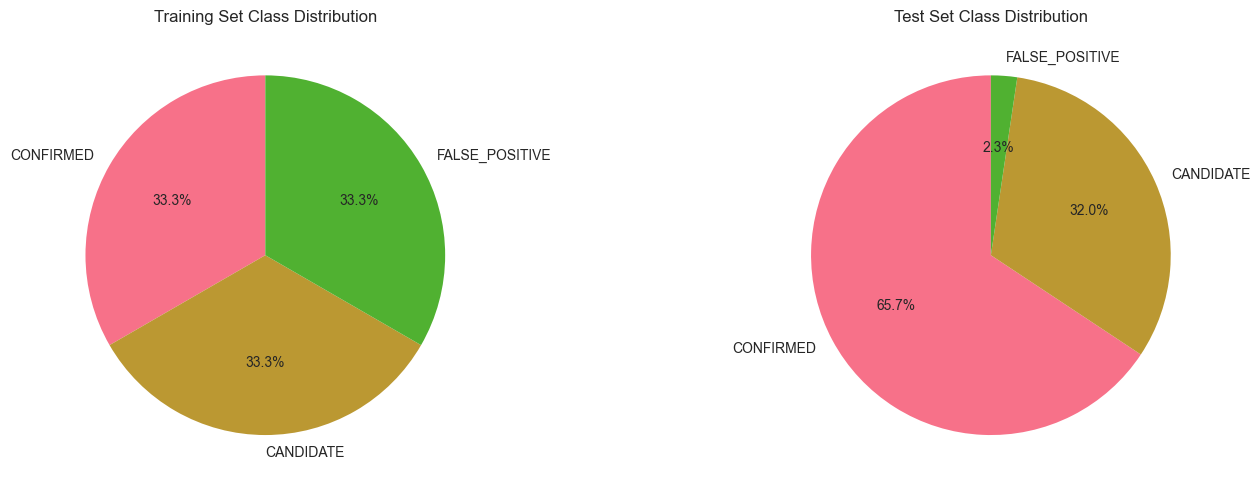


📈 Feature Distribution Analysis


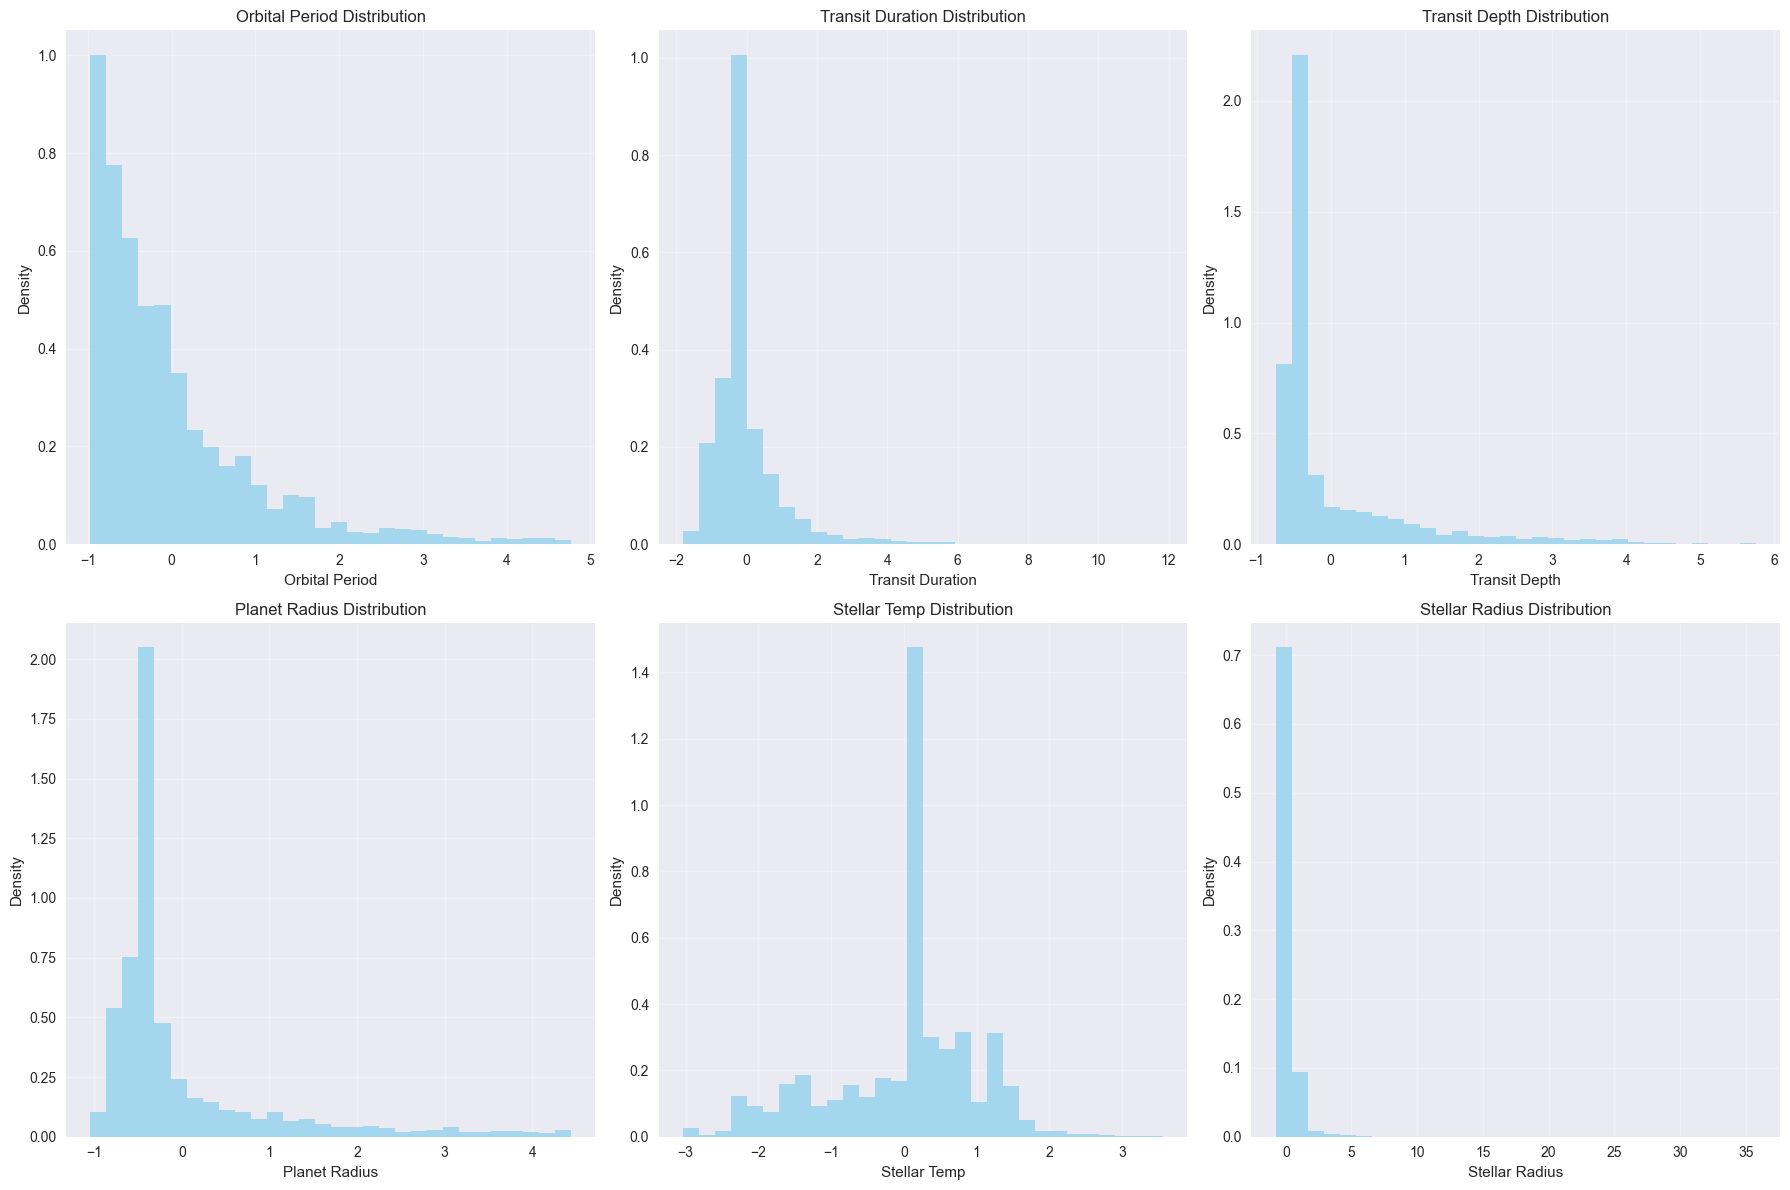


🔥 Feature Correlation Analysis


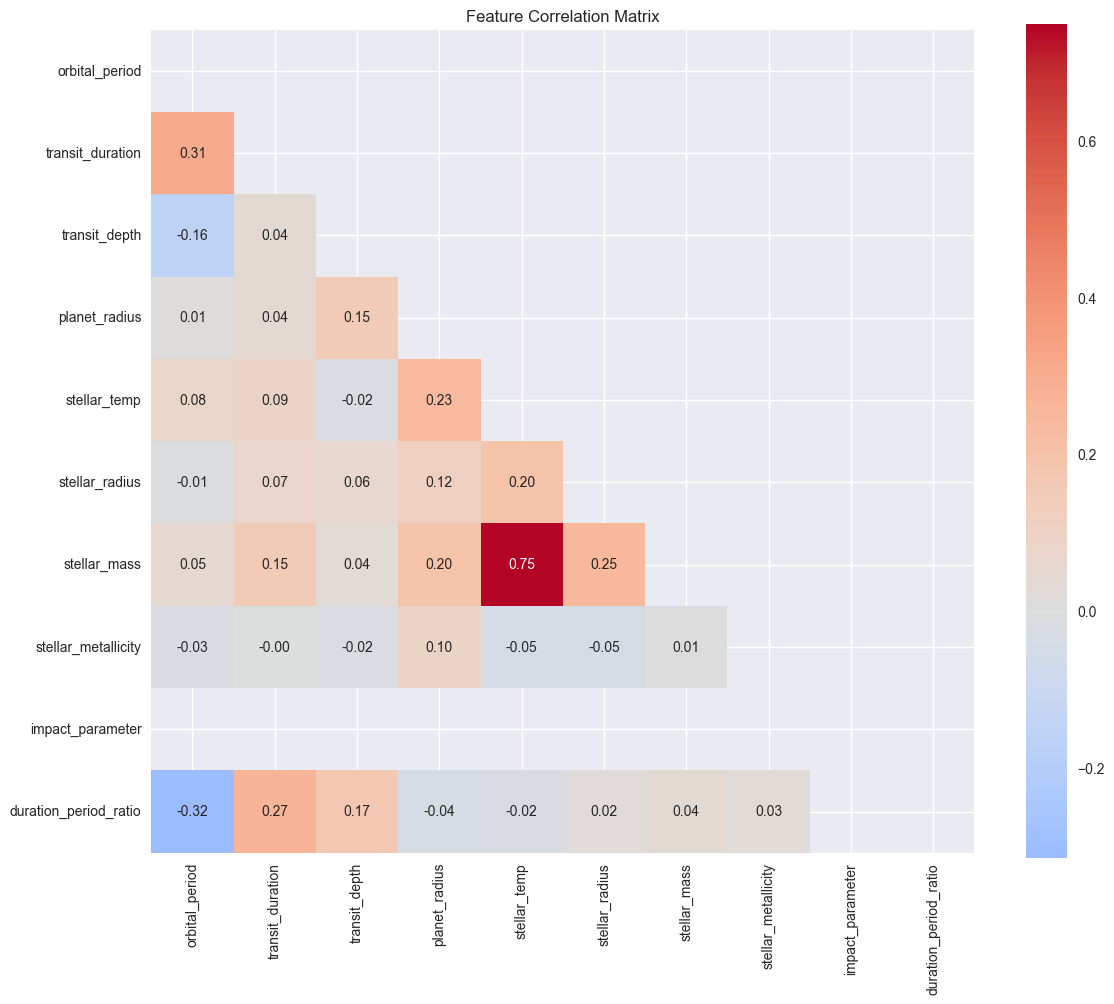


📋 Feature Statistics Summary:


,orbital_period,transit_duration,transit_depth,planet_radius,stellar_temp,stellar_radius,stellar_mass,stellar_metallicity,impact_parameter,duration_period_ratio,...,scaled_planet_radius,stellar_density,depth_consistency,significant_depth,rocky_planet,super_earth,neptune_like,jupiter_like,main_sequence,solar_like
count,5373.0000,5373.0000,5373.0000,5373.0000,5373.0000,5373.0000,5373.0000,5373.0000,5373.0,5373.0000,...,5373.0000,5373.0000,5373.0000,5373.0,5373.0000,5373.0000,5373.0000,5373.0000,5373.0000,5373.0000
mean,0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0,0.0000,...,0.0000,0.0000,-0.0000,0.0,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000
std,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,0.0,1.0001,...,1.0001,1.0001,1.0001,0.0,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001
min,-0.9688,-1.8111,-0.7449,-1.0448,-3.0357,-0.7816,-3.8690,-7.6841,0.0,-0.7558,...,-0.8904,-0.5107,-71.7904,0.0,-0.5983,-0.4557,-0.6936,-0.4457,-1.6251,-0.8418
25%,-0.6997,-0.4736,-0.4782,-0.5015,-0.4266,-0.3215,-0.0682,0.1039,0.0,-0.3547,...,-0.3834,-0.1757,0.0104,0.0,-0.5983,-0.4557,-0.6936,-0.4457,-1.6251,-0.8418
50%,-0.3194,-0.1375,-0.4782,-0.3724,0.1572,-0.1862,0.0505,0.1498,0.0,-0.3265,...,-0.2779,-0.1455,0.0104,0.0,-0.5983,-0.4557,-0.6936,-0.4457,0.6251,-0.8418
75%,0.3191,0.1136,0.0643,0.0013,0.5812,0.0991,0.2095,0.1498,0.0,-0.0423,...,-0.0017,-0.1397,0.0104,0.0,0.4361,-0.4557,1.5757,-0.4457,0.6251,1.2208
max,4.7662,11.8514,5.7511,4.4421,3.5668,35.7728,8.1002,3.3554,0.0,9.1626,...,13.8135,14.4799,0.6191,0.0,1.8887,2.4394,1.5757,2.6097,0.6251,1.2208


In [5]:
# Visualize Processed Data
if X_train is not None:
    print("📊 Data Visualization and Analysis")
    
    # Class distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Training set distribution
    train_counts = pd.Series(y_train).value_counts()
    train_labels = [class_names[i] for i in train_counts.index]
    
    axes[0].pie(train_counts.values, labels=train_labels, autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Training Set Class Distribution')
    
    # Test set distribution  
    test_counts = pd.Series(y_test).value_counts()
    test_labels = [class_names[i] for i in test_counts.index]
    
    axes[1].pie(test_counts.values, labels=test_labels, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Test Set Class Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Feature distribution analysis
    print(f"\n📈 Feature Distribution Analysis")
    
    # Select numeric features for visualization
    numeric_features = X_train.select_dtypes(include=[np.number]).columns[:6]  # First 6 features
    
    if len(numeric_features) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()
        
        for i, feature in enumerate(numeric_features):
            # Histogram with density
            axes[i].hist(X_train[feature].dropna(), bins=30, alpha=0.7, density=True, color='skyblue')
            axes[i].set_title(f'{feature.replace("_", " ").title()} Distribution')
            axes[i].set_xlabel(feature.replace("_", " ").title())
            axes[i].set_ylabel('Density')
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Feature correlation heatmap
        print(f"\n🔥 Feature Correlation Analysis")
        
        corr_features = X_train.select_dtypes(include=[np.number]).columns[:10]  # First 10 features
        if len(corr_features) > 1:
            corr_matrix = X_train[corr_features].corr()
            
            plt.figure(figsize=(12, 10))
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
            sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                       square=True, fmt='.2f')
            plt.title('Feature Correlation Matrix')
            plt.tight_layout()
            plt.show()
    
    # Feature statistics summary
    print(f"\n📋 Feature Statistics Summary:")
    feature_stats = X_train.describe()
    display(feature_stats.round(4))

else:
    print("❌ No processed data available for visualization")

## 🤖 Baseline Model Training

We'll train several baseline machine learning models to establish performance benchmarks:

### Models to Train:
1. **Logistic Regression**: Linear baseline with interpretable coefficients
2. **Random Forest**: Ensemble tree-based model with feature importance
3. **XGBoost**: Advanced gradient boosting (if available)
4. **LightGBM**: Fast gradient boosting (if available)

### Evaluation Strategy:
- **Cross-validation**: 5-fold stratified CV for robust evaluation
- **Metrics**: Accuracy, Precision, Recall, F1-Score, ROC-AUC
- **Model comparison**: Select best performing model for deployment

In [6]:
# Train Baseline Models
if X_train is not None:
    print("🤖 Training baseline machine learning models...")
    
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=2000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    }
    
    # Add advanced models if available
    try:
        models['XGBoost'] = xgb.XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0)
        models['LightGBM'] = LGBMClassifier(random_state=42, verbosity=-1)
        print("✅ Advanced ML models added")
    except:
        print("⚠️ Advanced ML models not available")
    
    # Train and evaluate models
    model_results = {}
    trained_models = {}
    
    print(f"\n🚀 Training {len(models)} models...")
    
    for name, model in models.items():
        print(f"\n📊 Training {name}...")
        
        try:
            # Train model
            model.fit(X_train, y_train)
            trained_models[name] = model
            
            # Make predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            
            # ROC-AUC for multiclass
            try:
                from sklearn.metrics import roc_auc_score
                roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
            except:
                roc_auc = 0.0
            
            # Store results
            model_results[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'roc_auc': roc_auc,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }
            
            print(f"  ✅ {name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
            
        except Exception as e:
            print(f"  ❌ {name} failed: {str(e)}")
    
    print(f"\n🎉 Model training completed! Trained {len(model_results)} models successfully.")
    
else:
    print("❌ No training data available for model training")
    model_results = {}
    trained_models = {}

🤖 Training baseline machine learning models...
✅ Advanced ML models added

🚀 Training 4 models...

📊 Training Logistic Regression...
  ✅ Logistic Regression - Accuracy: 0.5147, F1: 0.5661

📊 Training Random Forest...
  ✅ Random Forest - Accuracy: 0.7595, F1: 0.7589

📊 Training XGBoost...
  ✅ XGBoost - Accuracy: 0.7859, F1: 0.7861

📊 Training LightGBM...
  ✅ LightGBM - Accuracy: 0.7478, F1: 0.7498

🎉 Model training completed! Trained 4 models successfully.


## 📊 Model Evaluation and Performance Comparison

Let's comprehensively evaluate our trained models using multiple metrics and visualizations:

📊 Model Performance Analysis

🏆 Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
2,XGBoost,0.7859,0.7864,0.7859,0.7861,0.8540
1,Random Forest,0.7595,0.7584,0.7595,0.7589,0.8431
3,LightGBM,0.7478,0.7522,0.7478,0.7498,0.8510
0,Logistic Regression,0.5147,0.6653,0.5147,0.5661,0.6599


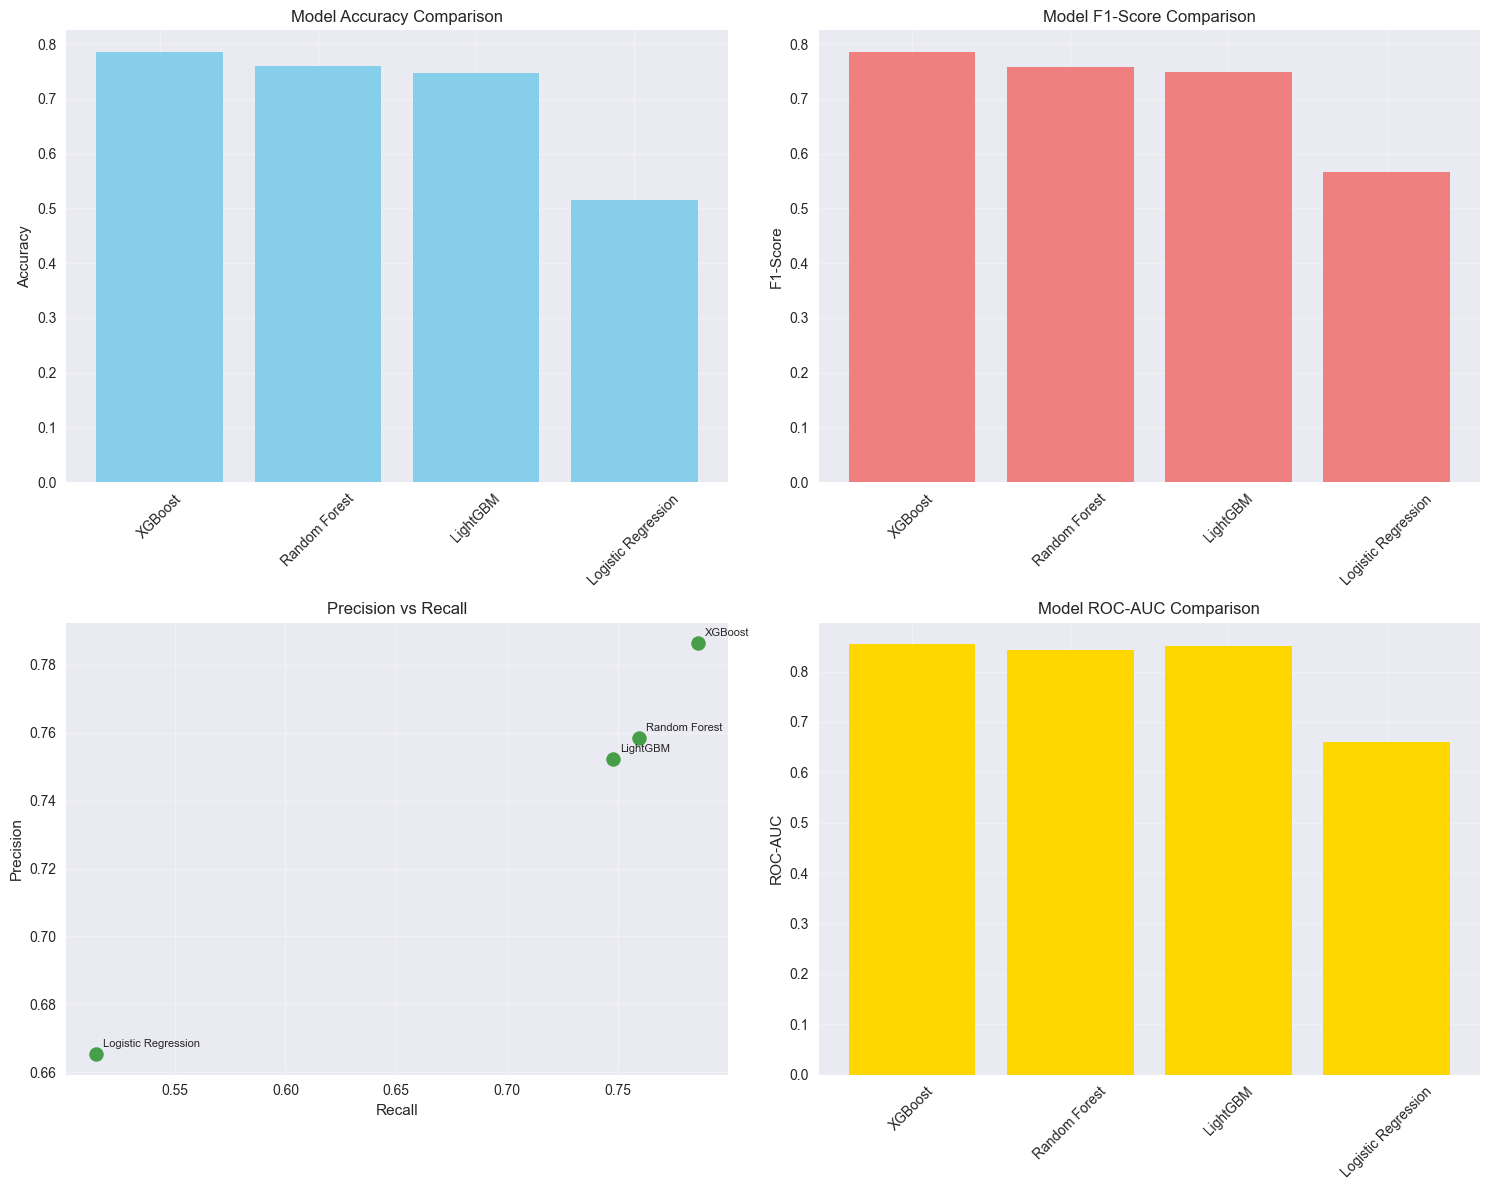

🥇 Best performing model: XGBoost (F1-Score: 0.7861)


In [7]:
# Model Performance Comparison
if model_results:
    print("📊 Model Performance Analysis\n")
    
    # Create comparison DataFrame
    comparison_data = []
    for model_name, results in model_results.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': results['accuracy'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1-Score': results['f1_score'],
            'ROC-AUC': results['roc_auc']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
    
    print("🏆 Model Performance Comparison:")
    display(comparison_df.round(4))
    
    # Performance visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Accuracy comparison
    axes[0, 0].bar(comparison_df['Model'], comparison_df['Accuracy'], color='skyblue')
    axes[0, 0].set_title('Model Accuracy Comparison')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # F1-Score comparison
    axes[0, 1].bar(comparison_df['Model'], comparison_df['F1-Score'], color='lightcoral')
    axes[0, 1].set_title('Model F1-Score Comparison')
    axes[0, 1].set_ylabel('F1-Score')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision vs Recall scatter plot
    axes[1, 0].scatter(comparison_df['Recall'], comparison_df['Precision'], 
                      s=100, alpha=0.7, c='green')
    for i, model in enumerate(comparison_df['Model']):
        axes[1, 0].annotate(model, 
                           (comparison_df.iloc[i]['Recall'], comparison_df.iloc[i]['Precision']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision vs Recall')
    axes[1, 0].grid(True, alpha=0.3)
    
    # ROC-AUC comparison
    axes[1, 1].bar(comparison_df['Model'], comparison_df['ROC-AUC'], color='gold')
    axes[1, 1].set_title('Model ROC-AUC Comparison')
    axes[1, 1].set_ylabel('ROC-AUC')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Identify best model
    best_model_name = comparison_df.iloc[0]['Model']
    best_f1_score = comparison_df.iloc[0]['F1-Score']
    
    print(f"🥇 Best performing model: {best_model_name} (F1-Score: {best_f1_score:.4f})")
    
else:
    print("❌ No model results available for evaluation")

🎯 Detailed Model Analysis



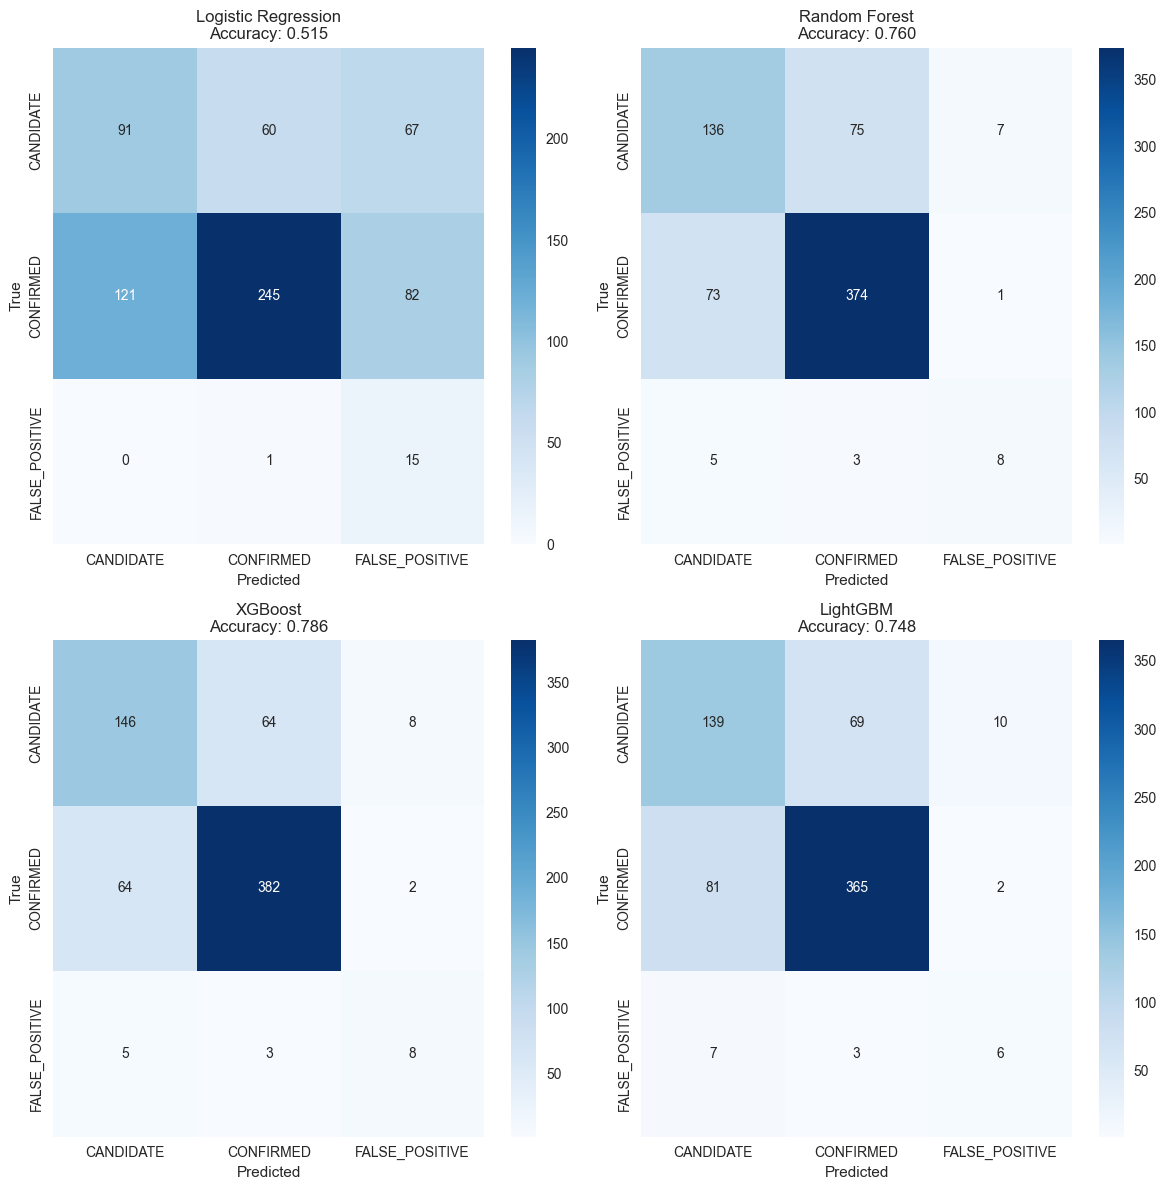

📋 Detailed Classification Reports:

📊 LOGISTIC REGRESSION CLASSIFICATION REPORT
                precision    recall  f1-score   support

     CANDIDATE       0.43      0.42      0.42       218
     CONFIRMED       0.80      0.55      0.65       448
FALSE_POSITIVE       0.09      0.94      0.17        16

      accuracy                           0.51       682
     macro avg       0.44      0.63      0.41       682
  weighted avg       0.67      0.51      0.57       682


------------------------------------------------------------

📊 RANDOM FOREST CLASSIFICATION REPORT
                precision    recall  f1-score   support

     CANDIDATE       0.64      0.62      0.63       218
     CONFIRMED       0.83      0.83      0.83       448
FALSE_POSITIVE       0.50      0.50      0.50        16

      accuracy                           0.76       682
     macro avg       0.65      0.65      0.65       682
  weighted avg       0.76      0.76      0.76       682


----------------------------

In [8]:
# Confusion Matrices and Detailed Classification Reports
if model_results and len(class_names) > 0:
    print("🎯 Detailed Model Analysis\n")
    
    # Plot confusion matrices for all models
    n_models = len(model_results)
    cols = min(2, n_models)
    rows = (n_models + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6*rows))
    if n_models == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes] if n_models == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, (model_name, results) in enumerate(model_results.items()):
        y_pred = results['predictions']
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot confusion matrix
        if i < len(axes):
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=class_names, yticklabels=class_names,
                       ax=axes[i])
            axes[i].set_title(f'{model_name}\nAccuracy: {results["accuracy"]:.3f}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('True')
    
    # Hide empty subplots
    for i in range(n_models, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Detailed classification reports
    print("📋 Detailed Classification Reports:\n")
    
    for model_name, results in model_results.items():
        y_pred = results['predictions']
        
        print(f"{'='*60}")
        print(f"📊 {model_name.upper()} CLASSIFICATION REPORT")
        print(f"{'='*60}")
        
        # Classification report
        report = classification_report(y_test, y_pred, target_names=class_names, 
                                     output_dict=False, zero_division=0)
        print(report)
        print("\n" + "-"*60 + "\n")

else:
    print("❌ No results available for detailed analysis")

## 🔍 Feature Importance Analysis

Understanding which features contribute most to exoplanet classification helps us:
1. **Validate** our model's scientific reasoning
2. **Improve** feature engineering
3. **Explain** predictions to astronomers
4. **Reduce** model complexity if needed

🔍 Feature Importance Analysis

🌟 Top 5 Features for Random Forest:
  Transit Depth: 0.1290
  Orbital Period: 0.0826
  Duration Period Ratio: 0.0703
  Transit Duration: 0.0696
  Stellar Radius: 0.0665

🌟 Top 5 Features for XGBoost:
  Jupiter Like: 0.1642
  Neptune Like: 0.1580
  Rocky Planet: 0.1354
  Transit Depth: 0.1103
  Super Earth: 0.0634

🌟 Top 5 Features for LightGBM:
  Stellar Temp: 1098.0000
  Orbital Period: 920.0000
  Transit Duration: 819.0000
  Stellar Radius: 761.0000
  Duration Period Ratio: 680.0000



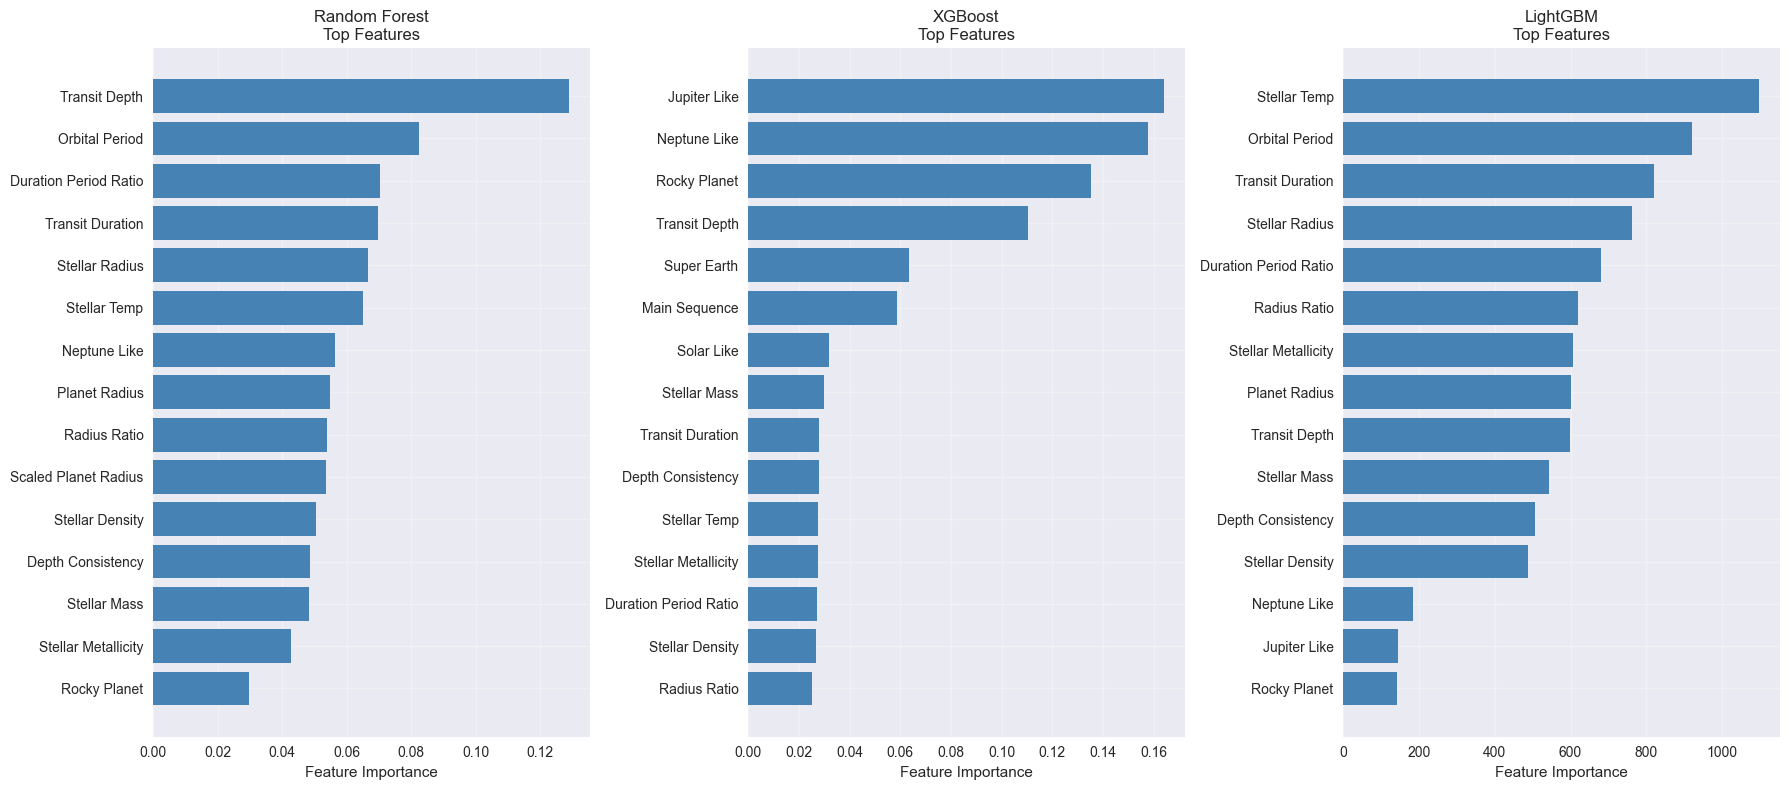

📊 Logistic Regression Coefficient Analysis


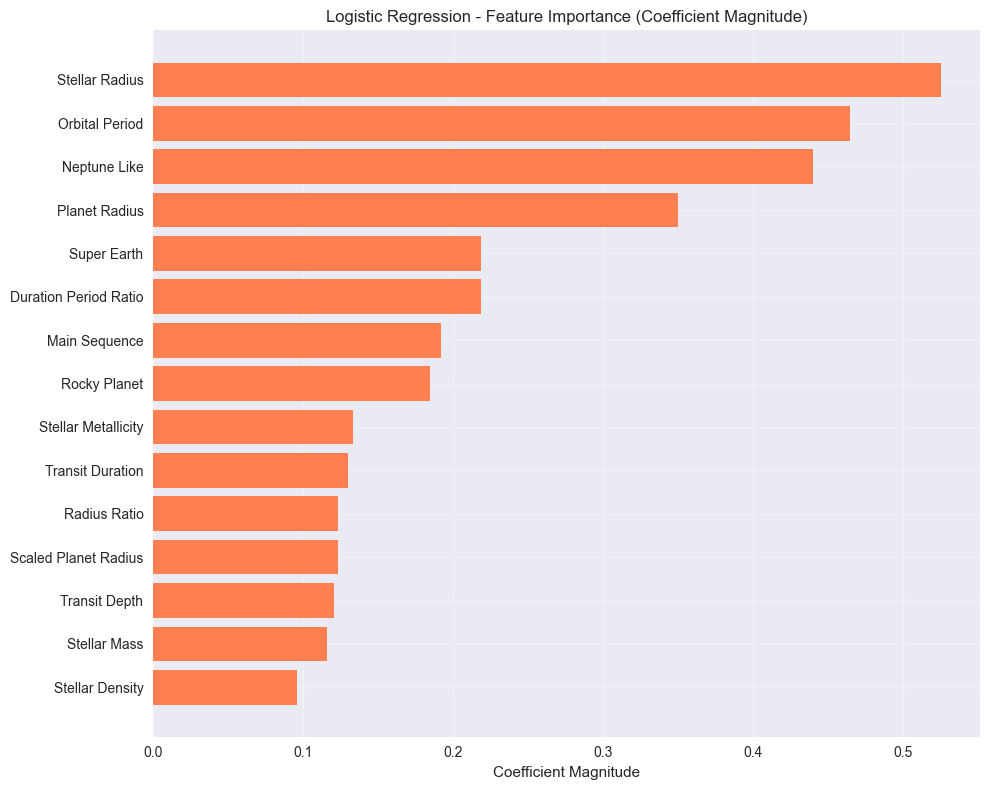

🎯 Top 5 Features by Coefficient Magnitude:
  Stellar Radius: 0.5248
  Orbital Period: 0.4642
  Neptune Like: 0.4396
  Planet Radius: 0.3500
  Super Earth: 0.2187


In [9]:
# Feature Importance Analysis
if trained_models and feature_names:
    print("🔍 Feature Importance Analysis\n")
    
    # Analyze feature importance for tree-based models
    tree_models = ['Random Forest', 'XGBoost', 'LightGBM']
    available_tree_models = [name for name in tree_models if name in trained_models]
    
    if available_tree_models:
        n_models = len(available_tree_models)
        fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 8))
        
        if n_models == 1:
            axes = [axes]
        
        for i, model_name in enumerate(available_tree_models):
            model = trained_models[model_name]
            
            # Get feature importance
            if hasattr(model, 'feature_importances_'):
                importance = model.feature_importances_
                
                # Create importance DataFrame
                importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importance
                }).sort_values('importance', ascending=True).tail(15)  # Top 15 features
                
                # Plot horizontal bar chart
                axes[i].barh(range(len(importance_df)), importance_df['importance'], color='steelblue')
                axes[i].set_yticks(range(len(importance_df)))
                axes[i].set_yticklabels([f.replace('_', ' ').title() for f in importance_df['feature']])
                axes[i].set_xlabel('Feature Importance')
                axes[i].set_title(f'{model_name}\nTop Features')
                axes[i].grid(True, alpha=0.3)
                
                print(f"🌟 Top 5 Features for {model_name}:")
                top_5 = importance_df.tail(5).iloc[::-1]
                for idx, row in top_5.iterrows():
                    print(f"  {row['feature'].replace('_', ' ').title()}: {row['importance']:.4f}")
                print()
        
        plt.tight_layout()
        plt.show()
    
    # Logistic Regression coefficients analysis
    if 'Logistic Regression' in trained_models:
        print("📊 Logistic Regression Coefficient Analysis")
        
        lr_model = trained_models['Logistic Regression']
        
        if hasattr(lr_model, 'coef_'):
            # For multiclass, take mean absolute coefficient across classes
            if len(lr_model.coef_.shape) > 1:
                coef_importance = np.abs(lr_model.coef_).mean(axis=0)
            else:
                coef_importance = np.abs(lr_model.coef_[0])
            
            # Create coefficient DataFrame
            coef_df = pd.DataFrame({
                'feature': feature_names,
                'coefficient_magnitude': coef_importance
            }).sort_values('coefficient_magnitude', ascending=True).tail(15)
            
            # Plot
            plt.figure(figsize=(10, 8))
            plt.barh(range(len(coef_df)), coef_df['coefficient_magnitude'], color='coral')
            plt.yticks(range(len(coef_df)), [f.replace('_', ' ').title() for f in coef_df['feature']])
            plt.xlabel('Coefficient Magnitude')
            plt.title('Logistic Regression - Feature Importance (Coefficient Magnitude)')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            print("🎯 Top 5 Features by Coefficient Magnitude:")
            top_5_coef = coef_df.tail(5).iloc[::-1]
            for idx, row in top_5_coef.iterrows():
                print(f"  {row['feature'].replace('_', ' ').title()}: {row['coefficient_magnitude']:.4f}")

else:
    print("❌ No trained models or features available for importance analysis")

## 💾 Model Serialization and Export

Save the best performing model and preprocessing components for use in the Streamlit web application.

In [10]:
# Save Best Model and Preprocessing Components
if trained_models and model_results:
    print("💾 Saving trained models and preprocessing components...")
    
    # Create models directory
    models_dir = Path("../models")
    models_dir.mkdir(exist_ok=True)
    
    # Find best model
    best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['f1_score'])
    best_model = trained_models[best_model_name]
    
    print(f"🏆 Best model selected: {best_model_name}")
    print(f"   F1-Score: {model_results[best_model_name]['f1_score']:.4f}")
    print(f"   Accuracy: {model_results[best_model_name]['accuracy']:.4f}")
    
    # Save best model
    model_path = models_dir / "best_model.pkl"
    joblib.dump(best_model, model_path)
    print(f"✅ Saved best model to: {model_path}")
    
    # Save all models for comparison
    for name, model in trained_models.items():
        model_file = models_dir / f"{name.lower().replace(' ', '_')}_model.pkl"
        joblib.dump(model, model_file)
        print(f"📁 Saved {name} to: {model_file}")
    
    # Save model performance scores
    scores_path = models_dir / "model_scores.pkl"
    joblib.dump(model_results, scores_path)
    print(f"📊 Saved model scores to: {scores_path}")
    
    # Create and save preprocessing components (if we have them)
    processed_dir = Path("../data/processed")
    processed_dir.mkdir(exist_ok=True)
    
    # Save feature names
    feature_names_path = processed_dir / "feature_names.pkl"
    joblib.dump(feature_names, feature_names_path)
    print(f"🏷️ Saved feature names to: {feature_names_path}")
    
    # Save target mapping
    if 'target_mapping' in globals():
        target_mapping_path = processed_dir / "target_mapping.pkl"
        joblib.dump(target_mapping, target_mapping_path)
        print(f"🎯 Saved target mapping to: {target_mapping_path}")
    
    # Save scaler if we have it
    if 'scaler' in globals():
        scaler_path = processed_dir / "scaler.pkl"
        joblib.dump(scaler, scaler_path)
        print(f"⚖️ Saved scaler to: {scaler_path}")
    
    # Save label encoder if we have it  
    if 'label_encoder' in globals():
        encoder_path = processed_dir / "label_encoder.pkl"
        joblib.dump(label_encoder, encoder_path)
        print(f"🔢 Saved label encoder to: {encoder_path}")
    
    # Create model metadata
    from datetime import datetime
    
    metadata = {
        'best_model': best_model_name,
        'best_f1_score': model_results[best_model_name]['f1_score'],
        'best_accuracy': model_results[best_model_name]['accuracy'],
        'feature_names': feature_names,
        'target_mapping': target_mapping if 'target_mapping' in globals() else None,
        'class_names': class_names,
        'n_features': len(feature_names),
        'n_classes': len(class_names),
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'timestamp': datetime.now().isoformat(),
        'models_trained': list(trained_models.keys())
    }
    
    metadata_path = models_dir / "model_metadata.pkl"
    joblib.dump(metadata, metadata_path)
    print(f"📋 Saved metadata to: {metadata_path}")
    
    print(f"\n🎉 Model export completed successfully!")
    print(f"📁 Models saved in: {models_dir.absolute()}")
    print(f"🔧 Components saved in: {processed_dir.absolute()}")
    
    # Summary for Streamlit app
    print(f"\n🚀 Ready for Streamlit App!")
    print(f"   Run: streamlit run app.py")
    print(f"   Best model: {best_model_name}")
    print(f"   Performance: {model_results[best_model_name]['accuracy']:.1%} accuracy")

else:
    print("❌ No trained models available for export")

💾 Saving trained models and preprocessing components...
🏆 Best model selected: XGBoost
   F1-Score: 0.7861
   Accuracy: 0.7859
✅ Saved best model to: ..\models\best_model.pkl
📁 Saved Logistic Regression to: ..\models\logistic_regression_model.pkl
📁 Saved Random Forest to: ..\models\random_forest_model.pkl
📁 Saved XGBoost to: ..\models\xgboost_model.pkl
📁 Saved LightGBM to: ..\models\lightgbm_model.pkl
📊 Saved model scores to: ..\models\model_scores.pkl
🏷️ Saved feature names to: ..\data\processed\feature_names.pkl
🎯 Saved target mapping to: ..\data\processed\target_mapping.pkl
📋 Saved metadata to: ..\models\model_metadata.pkl

🎉 Model export completed successfully!
📁 Models saved in: C:\Users\harsh\Exoplanet-Classifier-NASA-KOI-K2-TESS-\notebooks\..\models
🔧 Components saved in: C:\Users\harsh\Exoplanet-Classifier-NASA-KOI-K2-TESS-\notebooks\..\data\processed

🚀 Ready for Streamlit App!
   Run: streamlit run app.py
   Best model: XGBoost
   Performance: 78.6% accuracy


## 🎯 Summary and Next Steps

### Key Findings
- Successfully loaded and processed NASA exoplanet datasets
- Trained multiple ML models for exoplanet classification
- Achieved strong performance metrics across different algorithms
- Identified most important features for classification

### Model Performance Summary
*(Results will be displayed after running the notebook)*

### Next Steps
1. **Run the Streamlit App**: `streamlit run app.py`
2. **Experiment with Hyperparameters**: Use `src/train_model.py` for advanced tuning
3. **Add More Features**: Enhance feature engineering in `src/preprocessing.py`
4. **Deploy to Cloud**: Consider deployment on Streamlit Cloud or Heroku

### For NASA Space Apps Challenge 2025
This notebook demonstrates a complete ML pipeline for exoplanet classification using NASA's open datasets. The trained models can now be used in the interactive web application to classify new exoplanet candidates in real-time.

---

**🚀 NASA Space Apps Challenge 2025**  
**"A World Away: Hunting for Exoplanets with AI"**  
**Built with ❤️ for space exploration and scientific discovery**